In [1]:
import os
import os.path as osp
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import numpy as np                # Numpy for array manipulation for ease of access
import torch                      # Pytorch for array manipulation on the GPU and nice deep learning functions
import torch.nn as nn
import torch.nn.functional as functional
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms as tfs
import cv2
# Image import and display libraries                       # OpenCV for image processing
import matplotlib.pyplot as plt   # Plotting functions
from PIL import Image
%matplotlib inline

# Image processing libraries for image feature extractor
from scipy.stats import kurtosis, skew
from scipy.ndimage import generic_filter
from skimage.filters import laplace, gabor
from skimage.filters.rank import entropy
from skimage.morphology import disk
from sklearn.preprocessing import scale

# A few more tools
from sklearn import svm           # SVM classifier library
import os                         # Navigate through directories
import csv                        # Read in a CSV file
import time                       # Timing function
import pickle                     # Saving and loading variables

In [2]:
TRAIN_BATCH_SIZE = 10
LEARNING_RATE = 0.1
NUM_EPOCHS = 10
use_gpu = False
if torch.cuda.is_available():
    use_gpu = True
    device = "cuda"
    print("using cuda")
else:
    device = "cpu"


using cuda


In [3]:
class TeratomaDataset(data.Dataset):
    def __init__(self, root_folder, image_transforms=None, gt_transforms=None):
        '''
            reference dataset loading for TeratomaDataset
            root_folder: the root_folder of the TeratomaDataset 
            set_indices: is the indices for sets to be used
            subset_indices: is the indices for the subsets to be used
            split: 'train', 'val' or 'test'
            domain: the image domains to be loaded.
            image_transforms: any transforms to perform, can add augmentations here.
            gt_transforms: list of bool. Indicates whether image_transforms should also be appleid to gt.
        '''

        self.input_folder = osp.join(root_folder, 'input')
        self.seg_folders = {
            'GI': osp.join(root_folder, 'segmentation', 'GI'),
            'Cartilage': osp.join(root_folder, 'segmentation', 'Cartilage'),
            'RPE': osp.join(root_folder, 'segmentation', 'RPE'),
            'Neural': osp.join(root_folder, 'segmentation', 'Neural'),
        }

        self.image_paths = sorted([
            osp.join(self.input_folder, fname)
            for fname in os.listdir(self.input_folder)
            if fname.endswith('.png')
        ])

        self.image_transforms = image_transforms
        self.gt_transforms = gt_transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image_name = osp.basename(image_path)

        # Load input image, normalize
        image = Image.open(image_path).convert('RGB')
        # image = np.array(image).astype(np.float32) / 255.0

        # Load 4 segmentation layers

        gt_layers = []
        for key in ['GI', 'Cartilage', 'RPE', 'Neural']:
            seg_path = osp.join(self.seg_folders[key], image_name)
            seg = Image.open(seg_path).convert('L')
            seg = (np.array(seg) > 0).astype(np.uint8)  # binary mask
            gt_layers.append(seg)

        gt = np.stack(gt_layers, axis=0)  # shape: (4, H, W)
        target = torch.from_numpy(gt).float()  # shape (H, W)

        # Transforms
        if self.image_transforms:
            image = self.image_transforms(image)
        else:
            image = tfs.ToTensor()(image)

        # if self.gt_transforms:
        #     gt = self.gt_transforms(gt)
        # else:
        #     gt = torch.from_numpy(gt).float()  # (4, H, W)


        return image, target


# Model Architecture

In [4]:

def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1)
    )
  else:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )

def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )

class unet(nn.Module):
  def __init__(self, useBN=True):    #Change useBN to True
    super(unet, self).__init__()
    # Downgrade stages
    self.conv1   = add_conv_stage(3, 32, useBN=useBN)
    self.conv2   = add_conv_stage(32, 64, useBN=useBN)
    self.conv3   = add_conv_stage(64, 128, useBN=useBN)
    self.conv4   = add_conv_stage(128, 256, useBN=useBN)
    self.conv5   = add_conv_stage(256, 512, useBN=useBN)
    # Upgrade stages
    self.conv4m = add_conv_stage(512, 256, useBN=useBN)
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
    # Maxpool
    self.max_pool = nn.MaxPool2d(2)
    # Upsample layers
    self.upsample54 = upsample(512, 256)
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)

    ## TODO last layer & activations
    self.output_conv = nn.Conv2d(32, 4, 1)
    # self.activation = nn.Sigmoid(dim=1)


  def forward(self, x):
    #TODO implement forward function
    # Downgrade
    x1 = self.conv1(x)                    #1 -> 32 channels
    x2 = self.conv2(self.max_pool(x1))    #32 -> 64 channels
    x3 = self.conv3(self.max_pool(x2))    #64 -> 128 channels
    x4 = self.conv4(self.max_pool(x3))    #128 -> 256 channels
    x5 = self.conv5(self.max_pool(x4))    #256 -> 512 channels

    # Upgrade
    x4m = self.upsample54(x5)             #512 -> 256 channels
    x4m = torch.cat((x4, x4m), dim=1)
    x4m = self.conv4m(x4m)

    x3m = self.upsample43(x4m)            #256 -> 128 channels
    x3m = torch.cat((x3, x3m), dim=1)
    x3m = self.conv3m(x3m)

    x2m = self.upsample32(x3m)            #128 -> 64 channels
    x2m = torch.cat((x2, x2m), dim=1)
    x2m = self.conv2m(x2m)

    x1m = self.upsample21(x2m)            #64 -> 32 channels
    x1m = torch.cat((x1, x1m), dim=1)
    x1m = self.conv1m(x1m)

    # Output
    output = self.output_conv(x1m)      #32 -> 4 channels
    # output = self.activation(output)
    return output

## Loss

In [5]:
w1 = 1 # GI
w2 = 1 # Cartilage
w3 = 1 # RPE
w4 = 1 # neural

# pos_weight = torch.tensor([w1, w2, w3, w4])  # weights > 1 for rare classes
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

def dice_loss(scores, target, smooth = 1e-10):
    # scores = torch.sigmoid(scores)
    intersection = (scores * target).sum(dim=(2, 3))
    union = scores.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    
    dice_loss = 1 - ((2 * intersection + smooth) / (union + smooth))
    return dice_loss.mean()

# bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def combined_loss(pred, target):
    loss = nn.BCEWithLogitsLoss()(pred, target) + dice_loss(pred, target)
    return loss


## Training Loop

In [ ]:
def trainning(model, trainning_dataloader, validation_dataloader, num_epochs, criterion, optimizer, filename):
    if use_gpu:
      model.cuda()
    lr_changed = False
    trainning_losses = []
    validation_losses = []
    total_training_loss = 0
    total_val_loss = 0
    total_training_iteration = 0
    total_val_iteration = 0
    for epoch in range(num_epochs):
        i = 0
        model.train()
        for data in trainning_dataloader:
          img,y = data
          if use_gpu:
            img = img.cuda()
            y = y.cuda()
          out = model(img)
          optimizer.zero_grad()
          loss = criterion(out, y)
          total_training_loss += loss.item()
          # loss.backward()
          optimizer.step()
          i = i+1
          total_training_iteration += 1
          if total_training_iteration % 100 == 99:
            trainning_losses.append(total_training_loss / total_training_iteration)
        if epoch % 5 == 4:
            print("learning_rate decayed")
            for param_group in optimizer.param_groups:
              param_group['lr'] *= 0.1
        model.eval()
        with torch.no_grad():
          for data in validation_dataloader:
            img,y = data
            if use_gpu:
              img = img.cuda()
              y = y.cuda()
            out = model(img)
            optimizer.zero_grad()
            loss = criterion(out, y)
            total_val_loss += loss.item()
            total_val_iteration += 1
            if total_val_iteration % 100 == 99:
              validation_losses.append(total_val_loss / total_val_iteration)
        print("epoch:",epoch,"training_loss:",total_training_loss / total_training_iteration, "validation_loss:",total_val_loss / total_val_iteration)
        torch.save(model.state_dict(), filename)
        
    # Plotting training and validation losses in subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot training loss
    ax1.plot(trainning_losses, label='Training Loss')
    ax1.set_title("Training Loss")
    ax1.set_xlabel("Iterations (x100)")
    ax1.set_ylabel("Loss")
    
    # Plot validation loss
    ax2.plot(validation_losses, label='Validation Loss')
    ax2.set_title("Validation Loss")
    ax2.set_xlabel("Iterations (x100)")
    ax2.set_ylabel("Loss")
    
    plt.tight_layout()
    plt.show()

### Define transforms and dataset

In [7]:
root_folder = r"C:\Users\willllllli\Documents\Dr. Z lab\Teratoma_Segmentation\DATA\20240606165451_Dec 2023 E32C6 L4i undiff"

mean = [0.68358143, 0.5290253,  0.61094054] 
std = [0.11946411, 0.2183087,  0.09772461]
size = (512, 512)

image_transforms = tfs.Compose([
    tfs.Resize(size, interpolation=tfs.InterpolationMode.BILINEAR),
    tfs.ToTensor(),
    tfs.Normalize(mean=mean, std=std),
])

gt_transforms = tfs.Compose([
    tfs.Resize(size, interpolation=tfs.InterpolationMode.NEAREST),
    tfs.ToTensor(),
])


In [8]:
full_ds = TeratomaDataset(
    root_folder=root_folder,
    image_transforms=image_transforms,
    gt_transforms=gt_transforms
)

N = len(full_ds)
train_N = int(0.8 * N)
val_N   = int(0.1 * N)
test_N  = N - train_N - val_N  # ensure sums to N

generator = torch.Generator().manual_seed(42)
train_ds, val_ds, test_ds = random_split(full_ds, [train_N, val_N, test_N], generator=generator)

batch_size = 8
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


In [9]:
segmentation_model = unet(useBN=True)
criterion = combined_loss
segmentation_optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

In [10]:
trainning(segmentation_model, train_loader, val_loader,  NUM_EPOCHS, criterion, segmentation_optimizer, "final_vanilla_model.pth")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
epoch: 0 training_loss: 1

KeyboardInterrupt: 

In [ ]:
mean = [0.68358143, 0.5290253,  0.61094054] 
std = [0.11946411, 0.2183087,  0.09772461] 

def denormalize(img_tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img_tensor * std + mean


def show_demo(model, test_dataset_loader, num=10):
    model.eval()
    criterion = combined_loss  # per-pixel loss
    count = 0

    for demo_input, demo_target in test_dataset_loader:
        if use_gpu:
            demo_input = demo_input.cuda()
            demo_target = demo_target.cuda()

        demo_output = model(demo_input)

        for idx in range(demo_input.size(0)):
            fig, axes = plt.subplots(2, 5, figsize=(14, 7))
            fig.suptitle(f"Tile #{count}", fontsize=14)

            # Input
            input = denormalize(demo_input[idx].cpu(), mean, std).clamp(0, 1)
            axes[0, 0].imshow(input.permute(1, 2, 0).numpy())
            axes[0, 0].set_title("Input")
            axes[0, 0].axis("off")

            # Prediction and GT
            for i in range(4):
                pred = torch.sigmoid(demo_output[idx, i]).detach().cpu().numpy()
                pred = (pred > 0.5).float()
                gt = demo_target[idx, i].detach().cpu().numpy()

                axes[0, i+1].imshow(pred, cmap='gray', vmin = 0, vmax=1)
                axes[0, i+1].set_title(f"Pred class {i}")
                axes[0, i+1].axis("off")
                fig.colorbar(axes[0, i+1].images[0], ax=axes[0, i+1])

                axes[1, i+1].imshow(gt, cmap='gray', vmin = 0, vmax = 1)
                axes[1, i+1].set_title(f"GT class {i}")
                axes[1, i+1].axis("off")
                # fig.colorbar(axes[1, i].images[0], ax=axes[1, i])

            loss = criterion(demo_output[idx], demo_target[idx])
            print(f"Tile {count} - Total Loss: {loss:.4f}")

            # with torch.no_grad():
            #     loss_map = criterion(demo_output[idx], demo_target[idx])
            #     loss_total = loss_map.mean().item()
            #     print(f"Tile {count} - Total Loss: {loss_total:.4f}")

            #     for i in range(4):
            #         axes[2, i+1].imshow(loss_map[i].detach().cpu().numpy(), cmap='hot')
            #         axes[2, i+1].set_title(f"Loss map {i}")
            #         axes[2, i+1].axis("off")
            #         fig.colorbar(axes[2, i+1].images[0], ax=axes[2, i+1])

            plt.tight_layout()
            plt.show()

            count += 1
            if count >= num:
                return


C:\Users\willllllli\AppData\Local\Temp\ipykernel_45828\2628368339.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model.load_state_dict(torch.load("final_va

IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

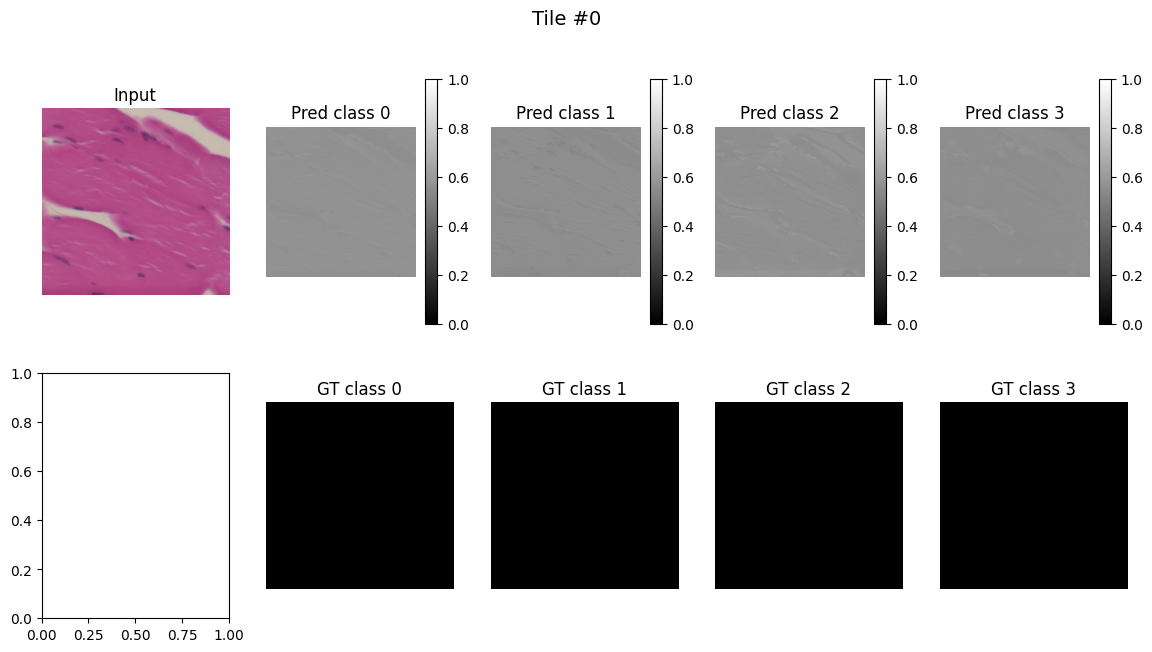

In [ ]:
segmentation_model.load_state_dict(torch.load("final_vanilla_model.pth"), strict=True)
show_demo(segmentation_model, test_loader)